In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from torch import nn
from pytorch_lightning import Trainer
from preprocessing.image_transform import ImageTransform
from preprocessing.seg_transforms import SegImageTransform
from datasets.gogoll import GogollDataModule
from datasets.agri import AgriDataModule
from systems.cycle_gan_system import CycleGANSystem
from models.generators import CycleGANGenerator
from models.discriminators import CycleGANDiscriminator
from utils.weight_initializer import init_weights
from torchvision.transforms import RandomResizedCrop
data_dir = './data'
domain = "domainB"

In [7]:
# Sanity Check
# transform = ImageTransform(img_size=256)
batch_size = 2

transform = SegImageTransform(img_size=256)

    # DataModule  -----------------------------------------------------------------
dm = GogollDataModule(data_dir, "domainA", transform, batch_size)  # used for trainingdm.prepare_data() # call first initialization function before we start asking for data
dm.prepare_data() # call first initialization function before we start asking for data
dm.setup() # call second initialization function before we start asking for data

dataloader = dm.val_dataloader() # get the loader that returns us data
batch = next(iter(dataloader)) # ask for the next batch of data
base, style = (batch['source'], batch['target'])

print('Input Shape {}, {}'.format(base.size(), style.size())) # check the shapes of the batch tensors

Input Shape torch.Size([2, 3, 256, 256]), torch.Size([2, 3, 256, 256])


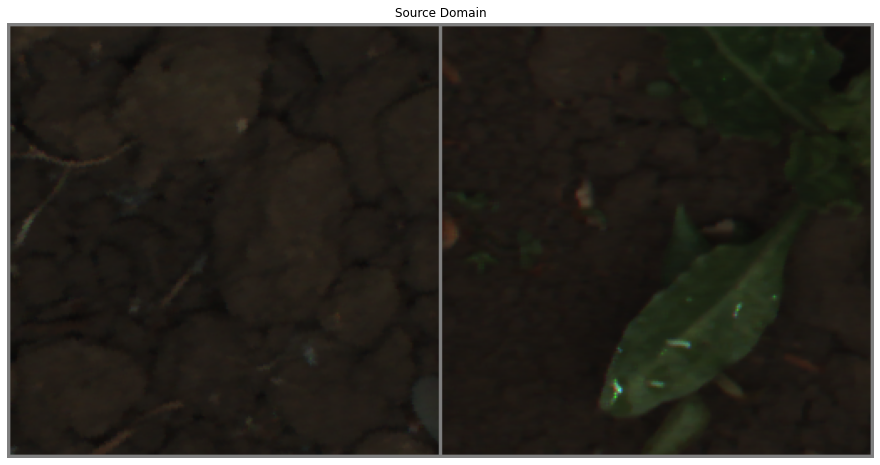

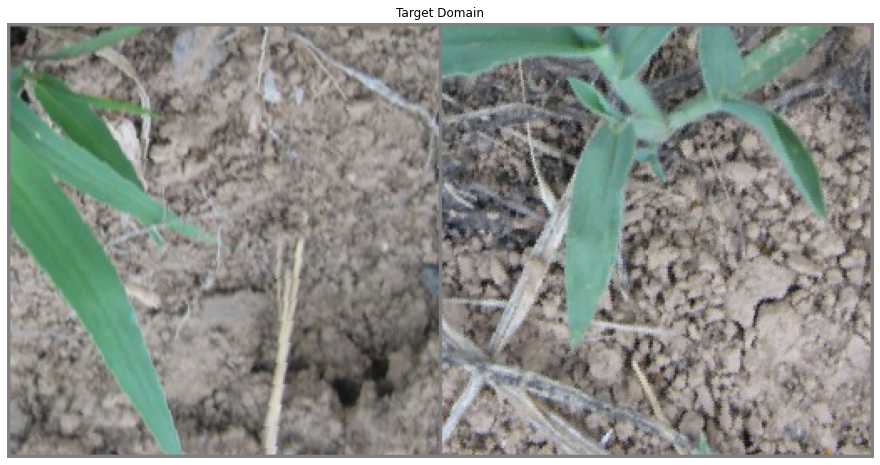

In [8]:
temp = make_grid(base, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Source Domain')
plt.show()

temp = make_grid(style, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Target Domain')
plt.show()

In [19]:
# Config  -----------------------------------------------------------------
transform = ImageTransform(img_size=256)
batch_size = 8
lr = {
    'G': 0.0002,
    'D': 0.0002
}
epoch = 180
seed = 42
reconstr_w = 10
id_w = 2

# DataModule  -----------------------------------------------------------------
dm = AgriDataModule(data_dir, transform, batch_size, domain=domain)
viz_set = AgriDataModule(data_dir, transform, 4, domain=domain)

G_basestyle = CycleGANGenerator(filter=32)
G_stylebase = CycleGANGenerator(filter=32)
D_base = CycleGANDiscriminator(filter=32)
D_style = CycleGANDiscriminator(filter=32)

# Init Weight  --------------------------------------------------------------
for net in [G_basestyle, G_stylebase, D_base, D_style]:
    init_weights(net, init_type='normal')

# LightningModule  --------------------------------------------------------------
vs = AgriDataModule(data_dir, transform, batch_size, domain=domain)
model = CycleGANSystem(G_basestyle, G_stylebase, D_base, D_style, lr, transform, reconstr_w, id_w)

# Trainer  --------------------------------------------------------------
trainer = Trainer(
    logger=False,
    max_epochs=epoch,
    gpus=1,
    checkpoint_callback=False,
    reload_dataloaders_every_epoch=True,
    num_sanity_val_steps=0,  # Skip Sanity Check
)

# Train
trainer.fit(model, datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                  | Params
-------------------------------------------------------------
0 | G_s2t              | CycleGANGenerator     | 10.5 M
1 | G_t2s              | CycleGANGenerator     | 10.5 M
2 | D_source           | CycleGANDiscriminator | 694 K 
3 | D_target           | CycleGANDiscriminator | 694 K 
4 | mae                | L1Loss                | 0     
5 | generator_loss     | MSELoss               | 0     
6 | discriminator_loss | MSELoss               | 0     
-------------------------------------------------------------
22.3 M    Trainable params
0         Non-trainable params
22.3 M    Total params
89.233    Total estimated model params size (MB)


ValueError: num_samples should be a positive integer value, but got num_samples=0